# Training 3D U-Net model for multi-class semantic segmentation

### Install pkgs

In [11]:
#!pip install git+https://github.com/copick/copick-utils.git matplotlib tqdm copick
#!pip install -q "monai-weekly[mlflow]"

### Copick configuration file template

```
{
    "config_type": "cryoet_data_portal",
    "name": "polnet",
    "description": "A Data Portal project.",
    "version": "1.0.0",

    "pickable_objects": [
        {
            "name": "membrane",
            "is_particle": false,
            "label": 1,
            "go_id": "GO:0016020",            
            "color": [150,150, 150, 255],
            "radius": 10
        },
        {
            "name": "adp-mitochondrial",
            "is_particle": true,
            "pdb_id": "6MRD",
            "go_id": "GO:1990220",
            "label": 2,
            "color": [  0, 117, 220, 255],
            "radius": 75,
            "map_threshold": 0.037
        },
        {
            "name": "alkaline-phosphate",
            "is_particle": true,
            "pdb_id": "1ZEF",
            "go_id": "UniProtKB:P05187",
            "label": 3,
            "color": [  0, 117, 220, 255],
            "radius": 75,
            "map_threshold": 0.037
        },
        {
            "name": "nucleosome",
            "is_particle": true,
            "pdb_id": "6UPH",
            "go_id": "GO:0000786",
            "label": 4,
            "color": [  0, 117, 220, 255],
            "radius": 65,
            "map_threshold": 0.037
        },        
        {
            "name": "ribosome",
            "is_particle": true,
            "pdb_id": "7TM3",
            "go_id": "GO:0022626",
            "label": 5,
            "color": [  0, 117, 220, 255],
            "radius": 165,
            "map_threshold": 0.037
        },
        {
            "name": "vault",
            "is_particle": true,
            "pdb_id": "7PKZ",
            "go_id": "UniProtKB:Q62667",
            "label": 6,
            "color": [  0, 117, 220, 255],
            "radius": 165,
            "map_threshold": 0.037
        },
        {
            "name": "virus-like-capsid",
            "is_particle": true,
            "pdb_id": "6NK5",
            "go_id": "GO:0170047",
            "label": 7,
            "color": [  0, 117, 220, 255],
            "radius": 140,
            "map_threshold": 0.037
        }             
    ],

    "overlay_root": "LOCAL_PATH",

    "overlay_fs_args": {
        "auto_mkdir": true
    },

    "dataset_ids": [10439]
}

```

In [1]:
import os
import numpy as np
from pathlib import Path
import torch
import torchinfo
from monai.config import print_config
from monai.data import DataLoader, CacheDataset, MetaTensor, decollate_batch
from monai.transforms import (
    Compose, 
    EnsureChannelFirstd, 
    ScaleIntensityRanged, 
    CropForegroundd, 
    Orientationd, 
    Spacingd, 
    EnsureTyped, 
    Activations, 
    AsDiscrete, 
    Resized, 
    RandFlipd, 
    RandRotate90d, 
    RandZoomd
)
from monai.networks.nets import UNet
from monai.losses import DiceLoss
from monai.metrics import DiceMetric
import mlflow
import mlflow.pytorch

/hpc/mydata/kevin.zhao/miniconda3/envs/mlchallenge/lib/python3.9/site-packages/ignite/handlers/checkpoint.py:17: DeprecationWarning: `TorchScript` support for functional optimizers is deprecated and will be removed in a future PyTorch release. Consider using the `torch.compile` optimizer instead.
  from torch.distributed.optim import ZeroRedundancyOptimizer


## Loading Polenet simulation dataset 10439 from CryoET Data Portal (tomogram + picks)

This dataset contains 27 tomograms. We will use the first 5 tomograms for training, and the following 2 tomograms for validation. Therefore, we will get the first 7 tomograms from the cryoET data portal in this notebook, and we will use the rest 20 tomograms for inference in a different notebook.

In [2]:
# Loading tomogram and painted masks from picks from copick-utils. Memberane does not have picks.
import zarr
import numpy as np
from tqdm import tqdm
from copick_utils1 import SegmentationFromPicks
from torch.utils.data import Dataset
import copick

copick_config_path = "/hpc/projects/group.czii/kevin.zhao/ml_challenge/example_notebooks/copick_config_10439_jonathon.json"
root = copick.from_file(copick_config_path)

particles = dict()
for po in root.config.pickable_objects:
    particles[po.name] = po.label

copick_dataset = SegmentationFromPicks(root)
data_dicts = []
for run in tqdm(root.runs[:7]):
    tomogram = copick_dataset.get_tomogram_array(run)
    segmentation = copick_dataset.get_painted_segmentation_array(run, user_id='user', session_id='0')
    data_dicts.append({"image": tomogram, "label": segmentation})

100%|██████████| 7/7 [02:42<00:00, 23.24s/it]


### Visualize the tomogram and the ground truth pick

Please be aware that the membrane does not have picks.

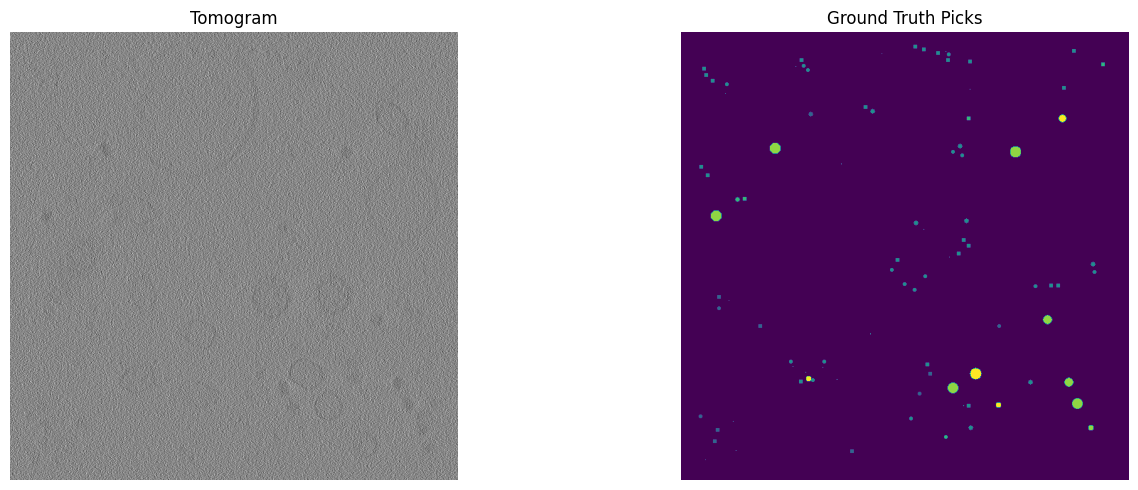

In [3]:
import matplotlib.pyplot as plt

# Plot the images
plt.figure(figsize=(15, 5))

# Original Image
plt.subplot(1, 2, 1)
plt.title('Tomogram')
plt.imshow(data_dicts[1]['image'][90],cmap='gray')
plt.axis('off')

# Original Image
plt.subplot(1, 2, 2)
plt.title('Ground Truth Picks')
plt.imshow(data_dicts[1]['label'][90])
plt.axis('off')

plt.tight_layout()
plt.show()

## Preparing dataloaders

In [8]:
# Define transforms for image and segmentation
transforms = Compose([
    EnsureChannelFirstd(keys=["image", "label"], channel_dim="no_channel"),
    ScaleIntensityRanged(keys=["image"], a_min=-57, a_max=164, b_min=0.0, b_max=1.0, clip=True),
    CropForegroundd(keys=["image", "label"], source_key="image"),
    Orientationd(keys=["image", "label"], axcodes="RAS"),
    Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
    EnsureTyped(keys=["image", "label"]),
    Resized(keys=["image", "label"], spatial_size=(96, 96, 96)),  # Resize all images and labels to the same size
    RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
    RandRotate90d(keys=["image", "label"], prob=0.5, spatial_axes=(1, 2)),
    RandZoomd(keys=["image", "label"], prob=0.2, min_zoom=0.9, max_zoom=1.1)
])

/hpc/mydata/kevin.zhao/miniconda3/envs/mlchallenge/lib/python3.9/site-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.5.
  warn_deprecated(argname, msg, warning_category)


In [9]:
train_batch_size = 1
val_batch_size = 1

train_files, val_files = data_dicts[:5], data_dicts[5:7]  
print(f"Number of training samples: {len(train_files)}")
print(f"Number of validation samples: {len(val_files)}")

train_ds = CacheDataset(data=train_files, transform=transforms)
val_ds = CacheDataset(data=val_files, transform=transforms)

train_loader = DataLoader(train_ds, batch_size=train_batch_size, shuffle=True, num_workers=4, pin_memory=torch.cuda.is_available())
val_loader = DataLoader(val_ds, batch_size=val_batch_size, num_workers=4, pin_memory=torch.cuda.is_available())

Number of training samples: 5
Number of validation samples: 2


Loading dataset: 100%|██████████| 2/2 [00:03<00:00,  1.52s/it]


## Setup model

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
# Create UNet, DiceLoss and Adam optimizer
model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=len(particles)+1,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
).to(device)

lr = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr)
loss_function = DiceLoss(to_onehot_y=True, softmax=True)  # softmax=True for multiclass
dice_metric = DiceMetric(include_background=False, reduction="mean", ignore_empty=True)  # must use onehot for multiclass

cuda


In [11]:
from monai.inferers import sliding_window_inference

post_pred = Compose([AsDiscrete(argmax=True, to_onehot=len(particles)+1)])
post_label = Compose([AsDiscrete(to_onehot=len(particles)+1)])

def train(train_loader, model, loss_function, metrics_function, optimizer, max_epochs=100):
    val_interval = 2
    best_metric = -1
    best_metric_epoch = -1
    epoch_loss_values = []
    metric_values = []
    for epoch in range(max_epochs):
        print("-" * 10)
        print(f"epoch {epoch + 1}/{max_epochs}")
        model.train()
        epoch_loss = 0
        step = 0
        for batch_data in train_loader:
            step += 1
            inputs, labels = (
                batch_data["image"].to(device),
                batch_data["label"].to(device),
            )
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            print(f"batch {step}/{len(train_ds) // train_loader.batch_size}, " f"train_loss: {loss.item():.4f}")
        epoch_loss /= step
        epoch_loss_values.append(epoch_loss)
        print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")
        mlflow.log_metric("train_loss", epoch_loss, step=epoch+1)

        if (epoch + 1) % val_interval == 0:
            model.eval()
            with torch.no_grad():
                for val_data in val_loader:
                    val_inputs, val_labels = (
                        val_data["image"].to(device),
                        val_data["label"].to(device),
                    )
                    roi_size = (96, 96, 96)
                    sw_batch_size = 4
                    val_outputs = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model)
                    val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]

                    val_labels = [post_label(i) for i in decollate_batch(val_labels)]
                    # compute metric for current iteration
                    metrics_function(y_pred=val_outputs, y=val_labels)

                metric = metrics_function.aggregate().item()
                mlflow.log_metric("validation metric", metric, step=epoch+1)
                metrics_function.reset()

                metric_values.append(metric)
                if metric > best_metric:
                    best_metric = metric
                    best_metric_epoch = epoch + 1
                    torch.save(model.state_dict(), os.path.join('./', "best_metric_model.pth"))
                    print("saved new best metric model")
                print(
                    f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                    f"\nbest mean dice: {best_metric:.4f} "
                    f"at epoch: {best_metric_epoch}"
                )

In [ ]:
from torchinfo import summary

mlflow.end_run()
mlflow.set_experiment('training 3D U-Net model for the cryoET ML Challenge')
epochs = 1000
with mlflow.start_run():
    params = {
        "epochs": epochs,
        "learning_rate": lr,
        "loss_function": loss_function.__class__.__name__,
        "metric_function": dice_metric.__class__.__name__,
        "optimizer": "Adam",
    }
    # Log training parameters.
    mlflow.log_params(params)

    # Log model summary.
    with open("model_summary.txt", "w") as f:
        f.write(str(summary(model)))
    mlflow.log_artifact("model_summary.txt")

    train(train_loader, model, loss_function, dice_metric, optimizer, max_epochs=epochs)

    # Save the trained model to MLflow.
    mlflow.pytorch.log_model(model, "model")



----------
epoch 1/1000
batch 1/5, train_loss: 0.9705
batch 2/5, train_loss: 0.9651
batch 3/5, train_loss: 0.9601
batch 4/5, train_loss: 0.9556
batch 5/5, train_loss: 0.9511
epoch 1 average loss: 0.9605
----------
epoch 2/1000
batch 1/5, train_loss: 0.9470
batch 2/5, train_loss: 0.9428
batch 3/5, train_loss: 0.9388
batch 4/5, train_loss: 0.9350
batch 5/5, train_loss: 0.9312
epoch 2 average loss: 0.9389
saved new best metric model
current epoch: 2 current mean dice: 0.0018
best mean dice: 0.0018 at epoch: 2
----------
epoch 3/1000
batch 1/5, train_loss: 0.9275
batch 2/5, train_loss: 0.9241
batch 3/5, train_loss: 0.9207
batch 4/5, train_loss: 0.9176
batch 5/5, train_loss: 0.9145
epoch 3 average loss: 0.9209
----------
epoch 4/1000
batch 1/5, train_loss: 0.9118
batch 2/5, train_loss: 0.9090
batch 3/5, train_loss: 0.9068
batch 4/5, train_loss: 0.9040
batch 5/5, train_loss: 0.9017
epoch 4 average loss: 0.9066
current epoch: 4 current mean dice: 0.0010
best mean dice: 0.0018 at epoch: 2
----